In [1]:
cd '/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_connectome/'

/Users/TingshanLiu/Desktop/2020 summer/TL_maggot/maggot_connectome


In [2]:
from pkg.data import load_maggot_graph
from joblib import Parallel, delayed
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import networkx as nx
from graspologic.utils import cartesian_product, import_graph, binarize, remove_loops
from graspologic.models import SBMEstimator
from graspologic.plot import heatmap
from graspologic.simulations import er_nm
from graspologic.models.sbm import _get_block_indices, _calculate_block_p, _block_to_full
from sklearn.utils import check_X_y
from scipy.stats import norm, binom_test
from scipy import stats
from hyppo.independence import Dcorr
import pandas as pd

In [3]:
context = sns.plotting_context(context="poster", font_scale=1.2)
sns.set_context(context)

In [4]:


def model_sbm(adj, cls_name):
    if len(cls_name) == 1:
        sbm = SBMEstimator()
        sbm.fit(binarize(adj), y=meta[cls_name].values)
    elif len(cls_name) == 2:  # crossing 'hemisphere' w/ another class
        multi_labels = meta[cls_name[0]].astype(str) + meta[cls_name[1]].astype(str)
        # assuming the first class is 'hemisphere'
        sbm = SBMEstimator()
        sbm.fit(binarize(adj), y=multi_labels)
    return sbm


def generate_rand_block_p(adj, y, rep=100, n_jobs=5):
    def _run():
        g = er_nm(len(adj), np.count_nonzero(adj), directed=True)
        sbm_ = SBMEstimator()
        sbm_.fit(binarize(g), y=y)
        return sbm_.block_p_
    rand_block_p = Parallel(n_jobs=n_jobs, verbose=1)(delayed(_run)()
        for _ in range(rep))
    return np.mean(rand_block_p, axis=0)


def compute_block_sig(adj, cls_name, p_mat, n_rand=100, test_less=False):
    labeled = np.where(meta[cls_name].ne(''))[0]
    adj_new = adj[np.ix_(labeled, labeled)]
    block_vert_inds, block_inds, block_inv = _get_block_indices(meta[cls_name].iloc[labeled])
    block_count = _calculate_block_p(binarize(adj_new), block_inds, block_vert_inds, True)
    rand_block_p = generate_rand_block_p(adj_new, meta[cls_name].iloc[labeled], n_rand)
    n_blocks = len(block_inds)
    block_pairs = cartesian_product(block_inds, block_inds)
    block_p = np.zeros((n_blocks, n_blocks))
    p_val_greater = []
    p_val_less = []
    for p in block_pairs:
        from_block = p[0]
        to_block = p[1]
        from_inds = block_vert_inds[from_block]
        to_inds = block_vert_inds[to_block]
        block = binarize(adj)[from_inds, :][:, to_inds]
        p_val_greater.append(binom_test(block_count[p[0], p[1]],
            block.size, rand_block_p[p[0], p[1]], alternative='greater'))
        if test_less:
            p_val_less.append(binom_test(block_count[p[0], p[1]],
                block.size, rand_block_p[p[0], p[1]], alternative='less'))
    return p_val_greater, p_val_less, block_pairs


def fdr(p, rate):
    sort_idx = np.argsort(p)
    n = len(p)
    q = np.zeros(n)
    for i in range(n):
        q[i] = sort_idx[i] * rate / n
    threshold = np.where(np.sort(p) < np.sort(q))[0][-1]
    sig_p = np.array(p)[sort_idx][threshold]
    return sig_p


def plot_heatmap(B, new_labels, p_val, block_pairs):
    fig = plt.figure(constrained_layout=True, figsize=(38,20))
    gs = fig.add_gridspec(12, 20)
    ax = fig.add_subplot(gs[2:13, 1:12])
    heatmap(B, xticklabels=new_labels, yticklabels=new_labels, ax=ax, norm=LogNorm())
    for i in range(len(block_pairs)):
        if p_val[i] <= 0.05:
            if p_val[i] <= 0.005:
                if p_val[i] <= 0.0005:
                    ax.text(block_pairs[i,1], block_pairs[i,0]+0.5,'***', color='w', fontsize=20)
                else:
                    ax.text(block_pairs[i,1], block_pairs[i,0]+0.5,'**', color='w', fontsize=20)
            else:
                ax.text(block_pairs[i,1], block_pairs[i,0]+0.5,'*', color='w', fontsize=20)
    ax.set_xticklabels(new_labels, rotation=45, ha='right')
    ax.set_yticklabels(new_labels, rotation=45)
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=30)
    ax.hlines(split, colors='gray', linestyles='dashed', linewidth=1.5, *ax.get_xlim())
    ax.vlines(split, colors='gray', linestyles='dashed', linewidth=1.5, *ax.get_xlim())
    ax = fig.add_subplot(gs[6:,15:])
    ax.hist(p_val, bins=[0, 0.0001, 0.001, 0.01, 0.1, 1])
    ax.set_yscale('symlog')
    ax.set_xscale('symlog',linthreshx=0.0001)
    ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])
    ax.set_xticklabels(ax.get_xticks(), fontsize=30, rotation=45)
    ax.set_yticklabels(ax.get_yticks(), fontsize=30)
    ax.set_xlabel('p-value', fontsize=30)
    ax.set_ylabel('count', fontsize=30)
    # plt.savefig('cls4_wei',transparent=False, facecolor='white', bbox_inches = "tight")


def plot_connectivity(cls, block_pairs, B, p_val, factor=1.5, correc='B'):
    new_keys = np.array(list(cls.keys()))
    counts = []
    for k in new_keys:
        idx = np.where(new_keys == k)[0][0]
        n = np.sum(meta['class_4'] == idx)
        counts.append(n)
    nodes = range(len(new_keys))
    labels = {}
    for n in nodes:
        labels[n] = new_keys[n].split('_')[-1]
    if correc == 'fdr':
        sig_p = fdr(p_val, 0.2)
    else:
        sig_p = 0.05 / len(p_val)
    edges = block_pairs[np.where(np.array(p_val) < sig_p)[0]]
    edges = [tuple(edges[i,:]) for i in range(edges.shape[0])]
    weights = B.ravel()[np.where(np.array(p_val) < sig_p)[0]]
    weights = [((i-np.min(weights)) / (np.max(weights)-np.min(weights))) * factor
        for i in weights]
    pos = {0:[0,11], 1:[2.5,11], 2:[5,11], 3:[7.5,11], 4:[10,11], 5:[12.5,11], 6:[15,11],
        7:[0,7], 8:[2,7], 9:[4,7], 10:[6,7], 11:[8,7], 12:[10,7], 13:[12,7], 14:[14,7],
        15:[0,1], 16:[2,1], 17:[3.5,3], 18:[3.5,-1.5], 19:[5,1],
        20:[4.5,-8], 21:[15,-13],
        22:[1,-19], 23:[4.5,-19], 
        24:[1,-23], 25:[4.5,-23], 26:[8,-23]}

    fig, ax = plt.subplots(1, figsize=(8,10))
    ax.set_xlim([-5,18])
    ax.set_ylim([-24,16.5])
    g = nx.MultiDiGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    nx.draw_networkx_nodes(g, node_size=counts, pos=pos, ax=ax)
    label_pos = pos.copy()
    offset_size = 0.8
    for i in pos.keys():
        # for j in range(2):
        #     label_pos[i][j] = pos[i][j] + counts[i]/1200 + offset_size[j]
        label_pos[i] = [j+counts[i]/1000+offset_size for j in pos[i]]
    # label_pos[13][1] = 1.5
    i = -1
    for e in g.edges:
        i += 1
        ax.annotate("",
                    xy=pos[e[1]], xycoords='data',
                    xytext=pos[e[0]], textcoords='data',
                    arrowprops=dict(arrowstyle="->", color="0.5",
                                    shrinkA=5+counts[e[0]]/50,
                                    shrinkB=5+counts[e[1]]/50,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=0.1",
                                    mutation_scale=10, lw=weights[i],
                                    ),
                    )
    ax.axis('off')
    for i in range(len(edges)):
        if edges[i][0] == edges[i][1]:
            gap = counts[edges[i][0]] / 600 + 0.3
            center = tuple([pos[edges[i][0]][0], pos[edges[i][0]][1]+gap])
            l = mpl.patches.Arc(center,0.3,0.5,0,-60,240,
                lw=weights[i], color='0.5')
            ax.add_patch(l)
    nx.draw_networkx_labels(g, pos=label_pos, labels=labels, font_color='r', ax=ax)
    ypos_ = [11,7,0.5,-8,-19,-23]
    texts = ['Input', '2nd-Order', '3rd-Order','4th-Order','Nth-1 Order','Nth Order']
    for i in range(len(texts)):
        ax.text(-2.5, ypos_[i], texts[i], ha='center', va='center', fontsize=10)

    plt.show()

def _calculate_block_p_wei(graph, block_inds, block_vert_inds, return_counts=False):
    n_blocks = len(block_inds)
    block_pairs = cartesian_product(block_inds, block_inds)
    block_p = np.zeros((n_blocks, n_blocks))
    for p in block_pairs:
        from_block = p[0]
        to_block = p[1]
        from_inds = block_vert_inds[from_block]
        to_inds = block_vert_inds[to_block]
        block = graph[from_inds, :][:, to_inds]
        # if np.count_nonzero(block) == 0:
        #     p = 0
        # else:
        # p = np.sum(block) / np.sqrt(len(from_inds) * len(to_inds))
        p = np.sum(block) / block.size
        block_p[from_block, to_block] = p
    return block_p

def weighted_sbm(adj, y):
    graph = import_graph(adj)
    check_X_y(graph, y)
    graph = remove_loops(graph)
    block_vert_inds, block_inds, block_inv = _get_block_indices(y)
    block_p = _calculate_block_p_wei(graph, block_inds, block_vert_inds)
    p_mat = _block_to_full(block_p, block_inv, graph.shape)
    p_mat = remove_loops(p_mat)
    return block_p, p_mat

def generate_rand_block_p_wei(adj, y, rep=100, n_jobs=5):
    def _run():
        g = er_nm(len(adj), np.count_nonzero(adj), directed=True)
        edges = adj[np.nonzero(adj)]
        np.random.shuffle(edges)
        g[np.nonzero(g)] = edges
        r_block_p, _ = weighted_sbm(g, y)
        return r_block_p
    rand_block_p = Parallel(n_jobs=n_jobs, verbose=1)(delayed(_run)()
        for _ in range(rep))
    return rand_block_p

def compute_block_sig_wei(block_p, adj, cls_name, n_rand=100):
    _, block_inds, _ = _get_block_indices(meta[cls_name])
    rand_block_p = generate_rand_block_p_wei(adj, meta[cls_name], n_rand)
    block_pairs = cartesian_product(block_inds, block_inds)
    p_val = []
    for p in block_pairs:
        null = [i[p[0], p[1]] for i in rand_block_p]
        if np.std(null) == 0:
            p_val.append(1)
        else:
            z_score = (block_p[p[0], p[1]] - np.mean(null)) / np.std(null)
            p_val.append(1 - norm.cdf(z_score))
    return p_val, block_pairs


#%%[markdown]
# ### load the data

In [5]:
mg = load_maggot_graph()
mg = mg[mg.nodes["paper_clustered_neurons"]]
mg.fix_pairs()
meta = mg.nodes.copy()
adj = mg.sum.adj.copy()

#%%[markdown]
# ### grap information on labels from different columns of meta

In [6]:
class_4 = {'input_AN': [["['sens_subclass_AN']"], 'all_class2'],
    'input_olf': [["['sens_subclass_ORN']"], 'all_class2'],
    'input_MN': [["['sens_subclass_MN']"], 'all_class2'],
    'input_thermo': [["['sens_subclass_thermo']"], 'all_class2'],
    'input_photo': [["['sens_subclass_photoRh5']",
        "['sens_subclass_photoRh6']"], 'all_class2'],
    'input_vtd': [["['sens_subclass_vtd']"], 'all_class2'],
    'input_ascending': [['ascendings'], 'simple_group'],
    'interneuron_uPN': [['uPN'], 'merge_class'],
    'interneuron_ALN': [['bLN','pLN','cLN'], 'merge_class'],
    'interneuron_unkLN': [],
    'interneuron_mPN': [['mPN'], 'merge_class'],
    'interneuron_tPN': [['tPN'], 'merge_class'],
    'interneuron_vPN': [['vPN'], 'merge_class'],
    'interneuron_LON': [['LON'], 'merge_class'],
    'interneuron_unkPN': [],
    'interneuron_LHN': [['LHNs'], 'simple_group'],
    'interneuron_KC': [['KCs'], 'simple_group'],
    'interneuron_MBIN': [['MBINs'], 'simple_group'],
    'interneuron_MBON': [['MBONs'], 'simple_group'],
    'interneuron_FBN': [['MB-FBNs'], 'simple_group'],
    'interneuron_CN': [['CNs'], 'simple_group'],
    'interneuron_unk': [['unk'], 'simple_group'],
    'output_pre-dVNC': [['pre-dVNCs'], 'simple_group'],
    'output_pre-dSEZ': [['pre-dSEZs'], 'simple_group'],
    'output_dVNC': [['dVNCs'], 'simple_group'],
    'output_dSEZ': [['dSEZs'], 'simple_group'],
    'output_RGN': [['RGNs'], 'simple_group'],
}

In [7]:
all_classes = {'class_4': class_4}
for ii, kk in enumerate(all_classes.keys()):
    meta[kk] = ''
    for idx, (k, v) in enumerate(all_classes[kk].items()):
        if len(v) == 1:
            meta.loc[meta[v[0]].eq(True).any(1), kk] = idx
        elif len(v) > 1:
            for i in range(len(v[0])):
                meta.loc[meta[v[1]].eq(v[0][i]), kk] = idx

# Some nodes that labeled as "PN" or "LN" in meta['simple_group']
# are labeled as things like "AN2", "MN2" etc in meta['merge_class']
# that do not specify which "PN" or "LN"
# even though meta['merge_class'] gives detailed labels for the majority of nodes
# so in order not to exclude any node, we will label them as "unkPN" or "unkLN"
idx = list(class_4.keys()).index("interneuron_unkPN")
meta.loc[(meta['class_4'].eq('') & meta['simple_group'].eq('PNs')), 'class_4'] = idx
idx = list(class_4.keys()).index("interneuron_unkLN")
meta.loc[(meta['class_4'].eq('') & meta['simple_group'].eq('LNs')), 'class_4'] = idx
print(np.sum(meta['class_4'].ne('')))

2874


In [8]:
# class_1: 3-block (input, interneuron, output)
meta['class_1'] = ''
meta.loc[meta['class_4'].isin(range(7)), 'class_1'] = 0
meta.loc[meta['class_4'].isin(range(7, 22)), 'class_1'] = 1
meta.loc[meta['class_4'].isin(range(22, 27)), 'class_1'] = 2 
print(np.sum(meta['class_1'].ne('')))

2874


In [9]:
# class_2: break up inter into 1st, 2nd,...,nth order
meta['class_2'] = ''
meta.loc[meta['class_4'].isin(range(7)), 'class_2'] = 0
meta.loc[meta['class_4'].isin(range(7, 15)), 'class_2'] = 1
meta.loc[meta['class_4'].isin(range(15,20)), 'class_2'] = 2 
meta.loc[meta['class_4'].isin([20]), 'class_2'] = 3
meta.loc[meta['class_4'].isin([21]), 'class_2'] = 4
meta.loc[meta['class_4'].isin([22,23]), 'class_2'] = 5
meta.loc[meta['class_4'].isin([24,25,26]), 'class_2'] = 6
print(np.sum(meta['class_2'].ne('')))

#%%[markdown]
# ### fit an SBM for each category and test significance on the B_ij's

2874


In [10]:
all_classes = ['class_1', 'class_2', 'simple_group', 'class_4', 'hemisphere']
sbms = []
sbms_hemi = []
for k in all_classes:
    sbms.append(model_sbm(adj, [k]))
    if k is not 'hemisphere':
        sbms_hemi.append(model_sbm(adj, ['hemisphere', k]))

/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.7-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.7-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/scikit_learn-0.24.1-py3.7-macosx-10.7-x86_64.egg/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), fo

In [11]:
# significance test: 
# - H0: $B_ij = p$ (expected single block prob for random graphs ER(n, m);
# H1: $B_ij > p$ (also checked $B_ij < p$ for 3-block SBMs)
# - P-value: obtained empirically by samping from ER(n, m) (500) and binomial test

p_val_all = {}
block_pairs_all = {}
cls_names = ['hemisphere', 'class_1', 'class_2', 'simple_group', 'class_4']
for i,cls_n in enumerate(cls_names):
    sbm_id = all_classes.index(cls_n)
    if i >= 2:
        p_val_all[cls_n], _,  block_pairs_all[cls_n] =\
            compute_block_sig(adj, cls_n, sbms[sbm_id].p_mat_, 500)
    else:
        p_val_all[cls_n+'greater'], p_val_all[cls_n+'less'], block_pairs_all[cls_n] =\
            compute_block_sig(adj, cls_n, sbms[sbm_id].p_mat_, 500, True)        

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/joblib-1.0.0-py3.7.egg/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   37.3s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.2min
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:  3.6min finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   14.6s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:  2.9min finishe

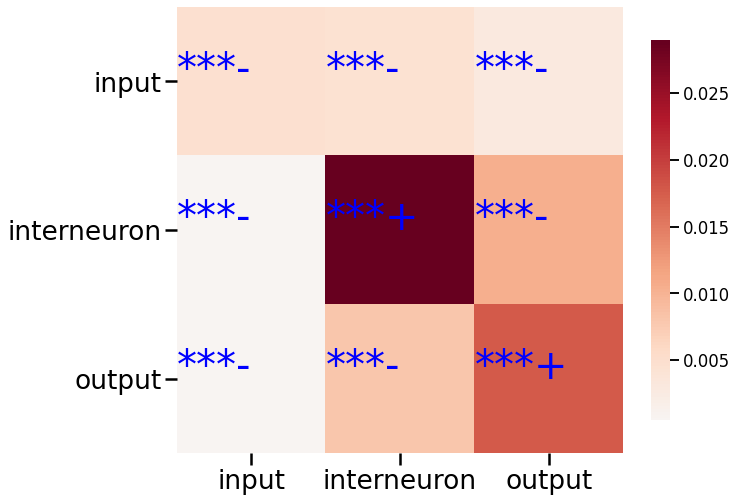

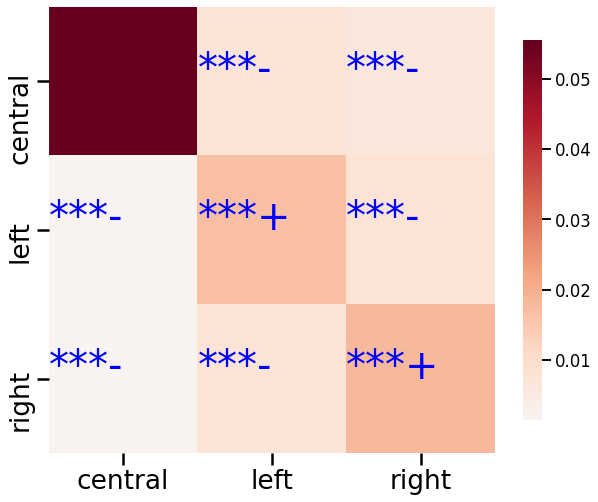

In [12]:
# for 3-block SBM
# cls = class_4
# labels = list(cls.keys())
# new_labels = list(np.unique([i.split('_')[0] for i in labels]))
labels = [['input','interneuron','output'],['central','left','right']]
cls_names = ['class_1','hemisphere']
sigs = np.array([0.05,0.005,0.0005])
for i,cls_n in enumerate(cls_names):
    sbm_id = all_classes.index(cls_n)
    new_labels = labels[i]
    fig,ax = plt.subplots(1, figsize=(10,10))
    heatmap(sbms[sbm_id].block_p_, xticklabels=new_labels, yticklabels=new_labels, ax=ax)
    for i in range(len(block_pairs_all[cls_n])):
        n1 = np.where(p_val_all[cls_n + 'greater'][i] <= sigs)[0]
        if len(n1) != 0:
            ax.text(block_pairs_all[cls_n][i,1],block_pairs_all[cls_n][i,0]+0.5,
                (n1[-1]+1)*'*'+'+', color='b', fontsize=40)
        n2 = np.where(p_val_all[cls_n + 'less'][i] <= sigs)[0]
        if len(n2) != 0:
            ax.text(block_pairs_all[cls_n][i,1], block_pairs_all[cls_n][i,0]+0.5,
                (n2[-1]+1)*'*'+'-', color='b', fontsize=40)

/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


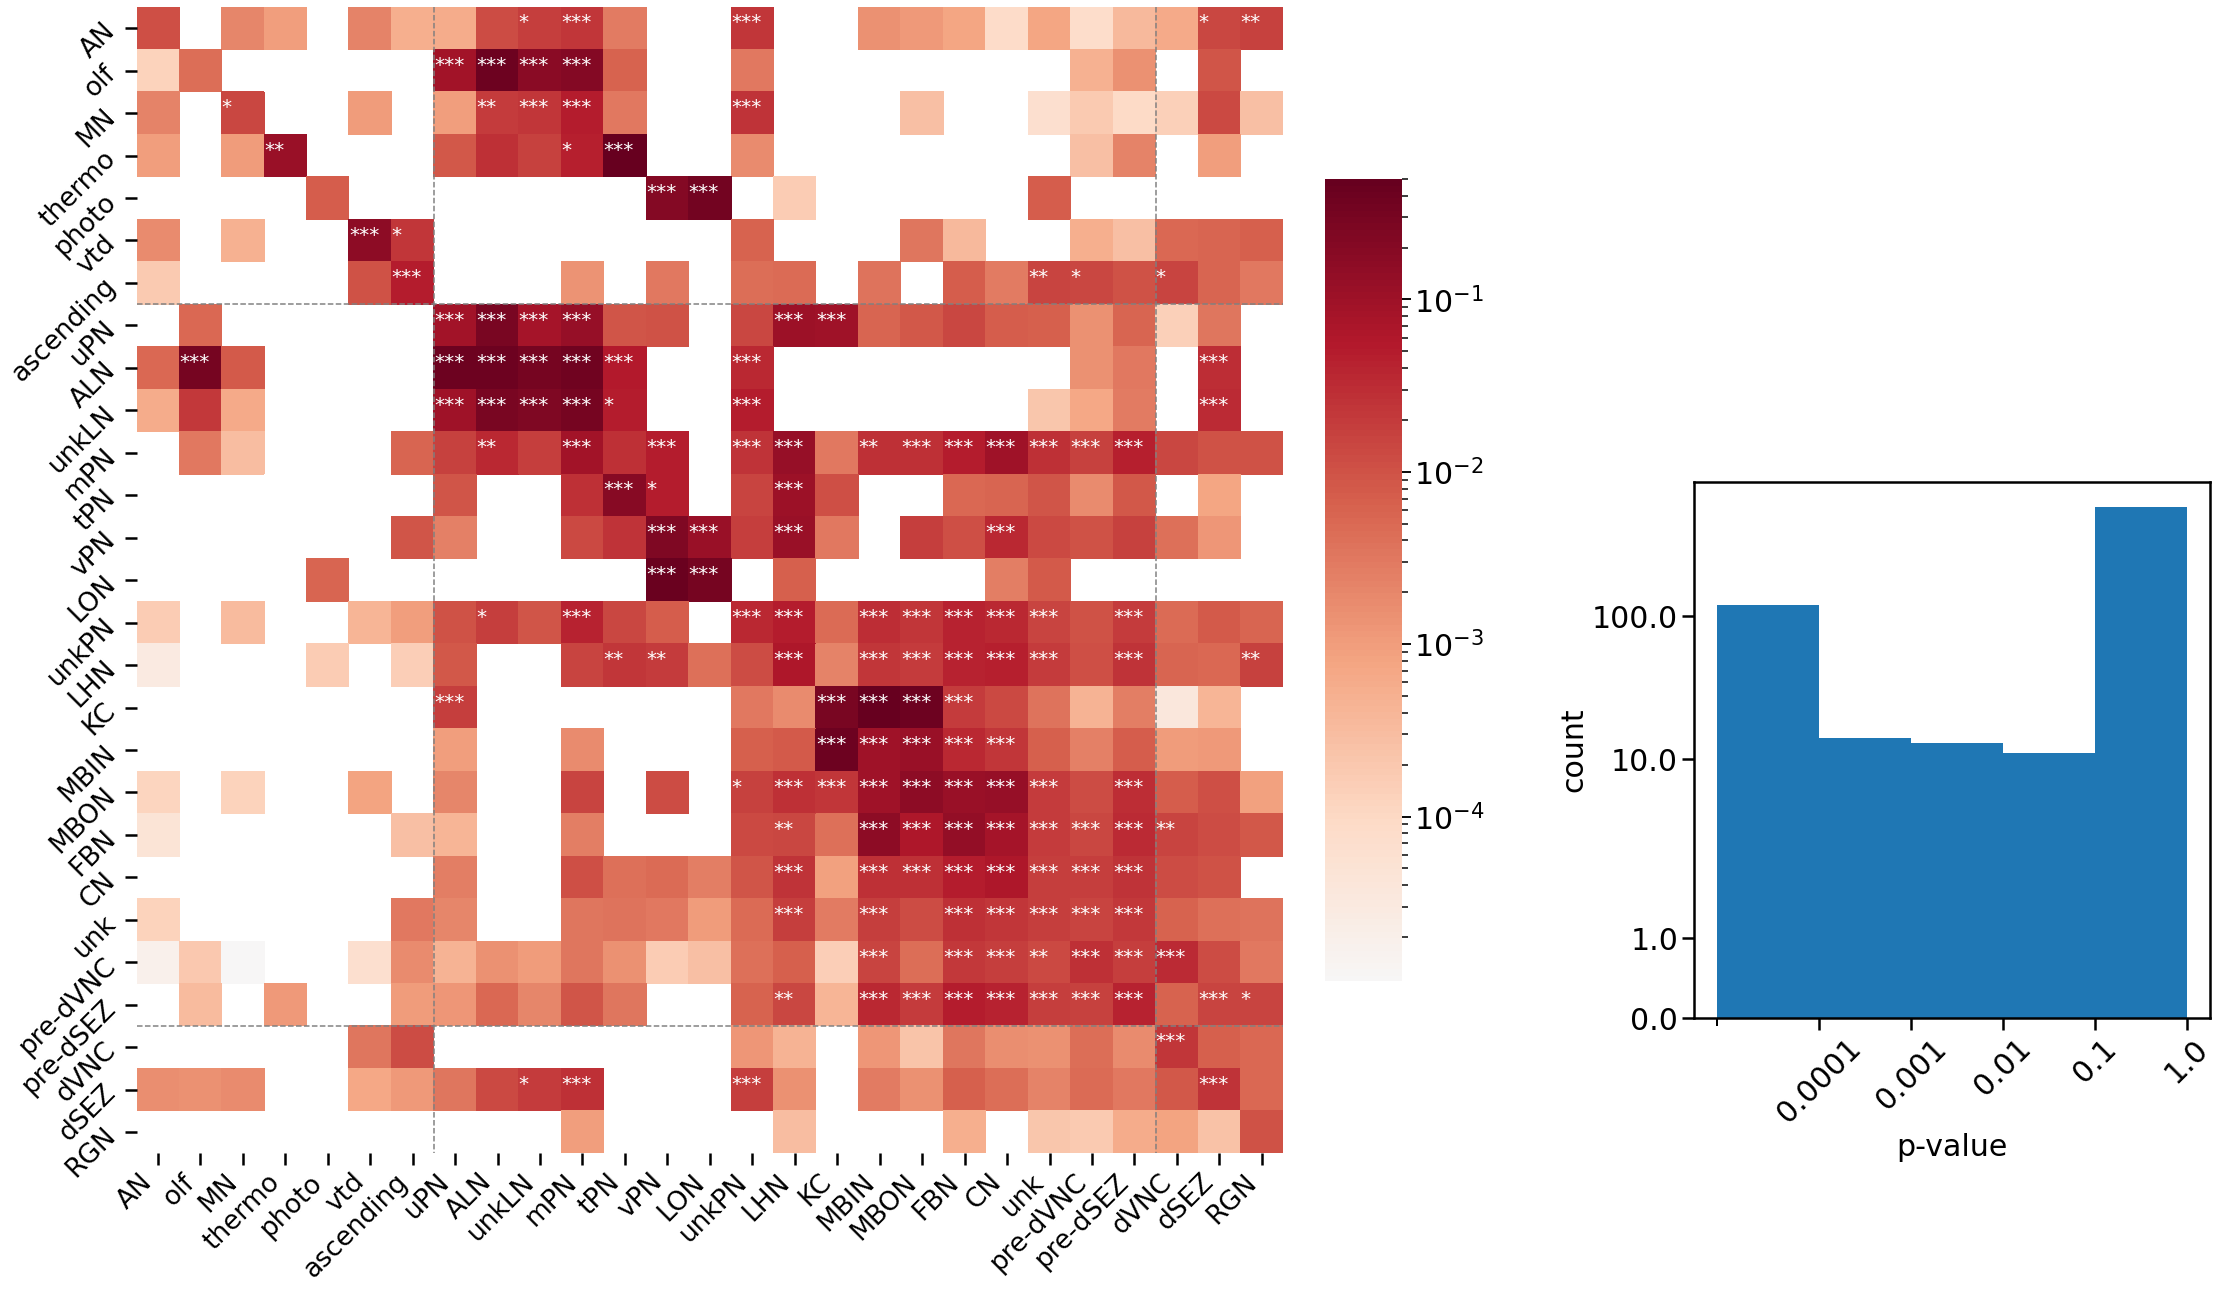

In [13]:
# for class_4
cls = class_4
cls_name = 'class_4'
labels = list(cls.keys())
new_labels = [i.split('_')[-1] for i in labels]
sbm_id = all_classes.index(cls_name)
B = sbms[sbm_id].block_p_.copy()
split = [7, 24]
plot_heatmap(B, new_labels, p_val_all[cls_name], block_pairs_all[cls_name])

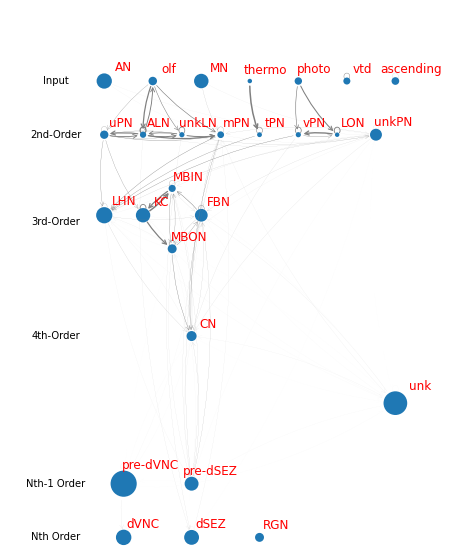

In [14]:
# connectivity plot: node size ~ sqart(no. neurons);
# edge width: thresholding (Bonferroni or FDR correction?) -> ~ edge density
plot_connectivity(class_4, block_pairs_all[cls_name], B, p_val_all[cls_name])

/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


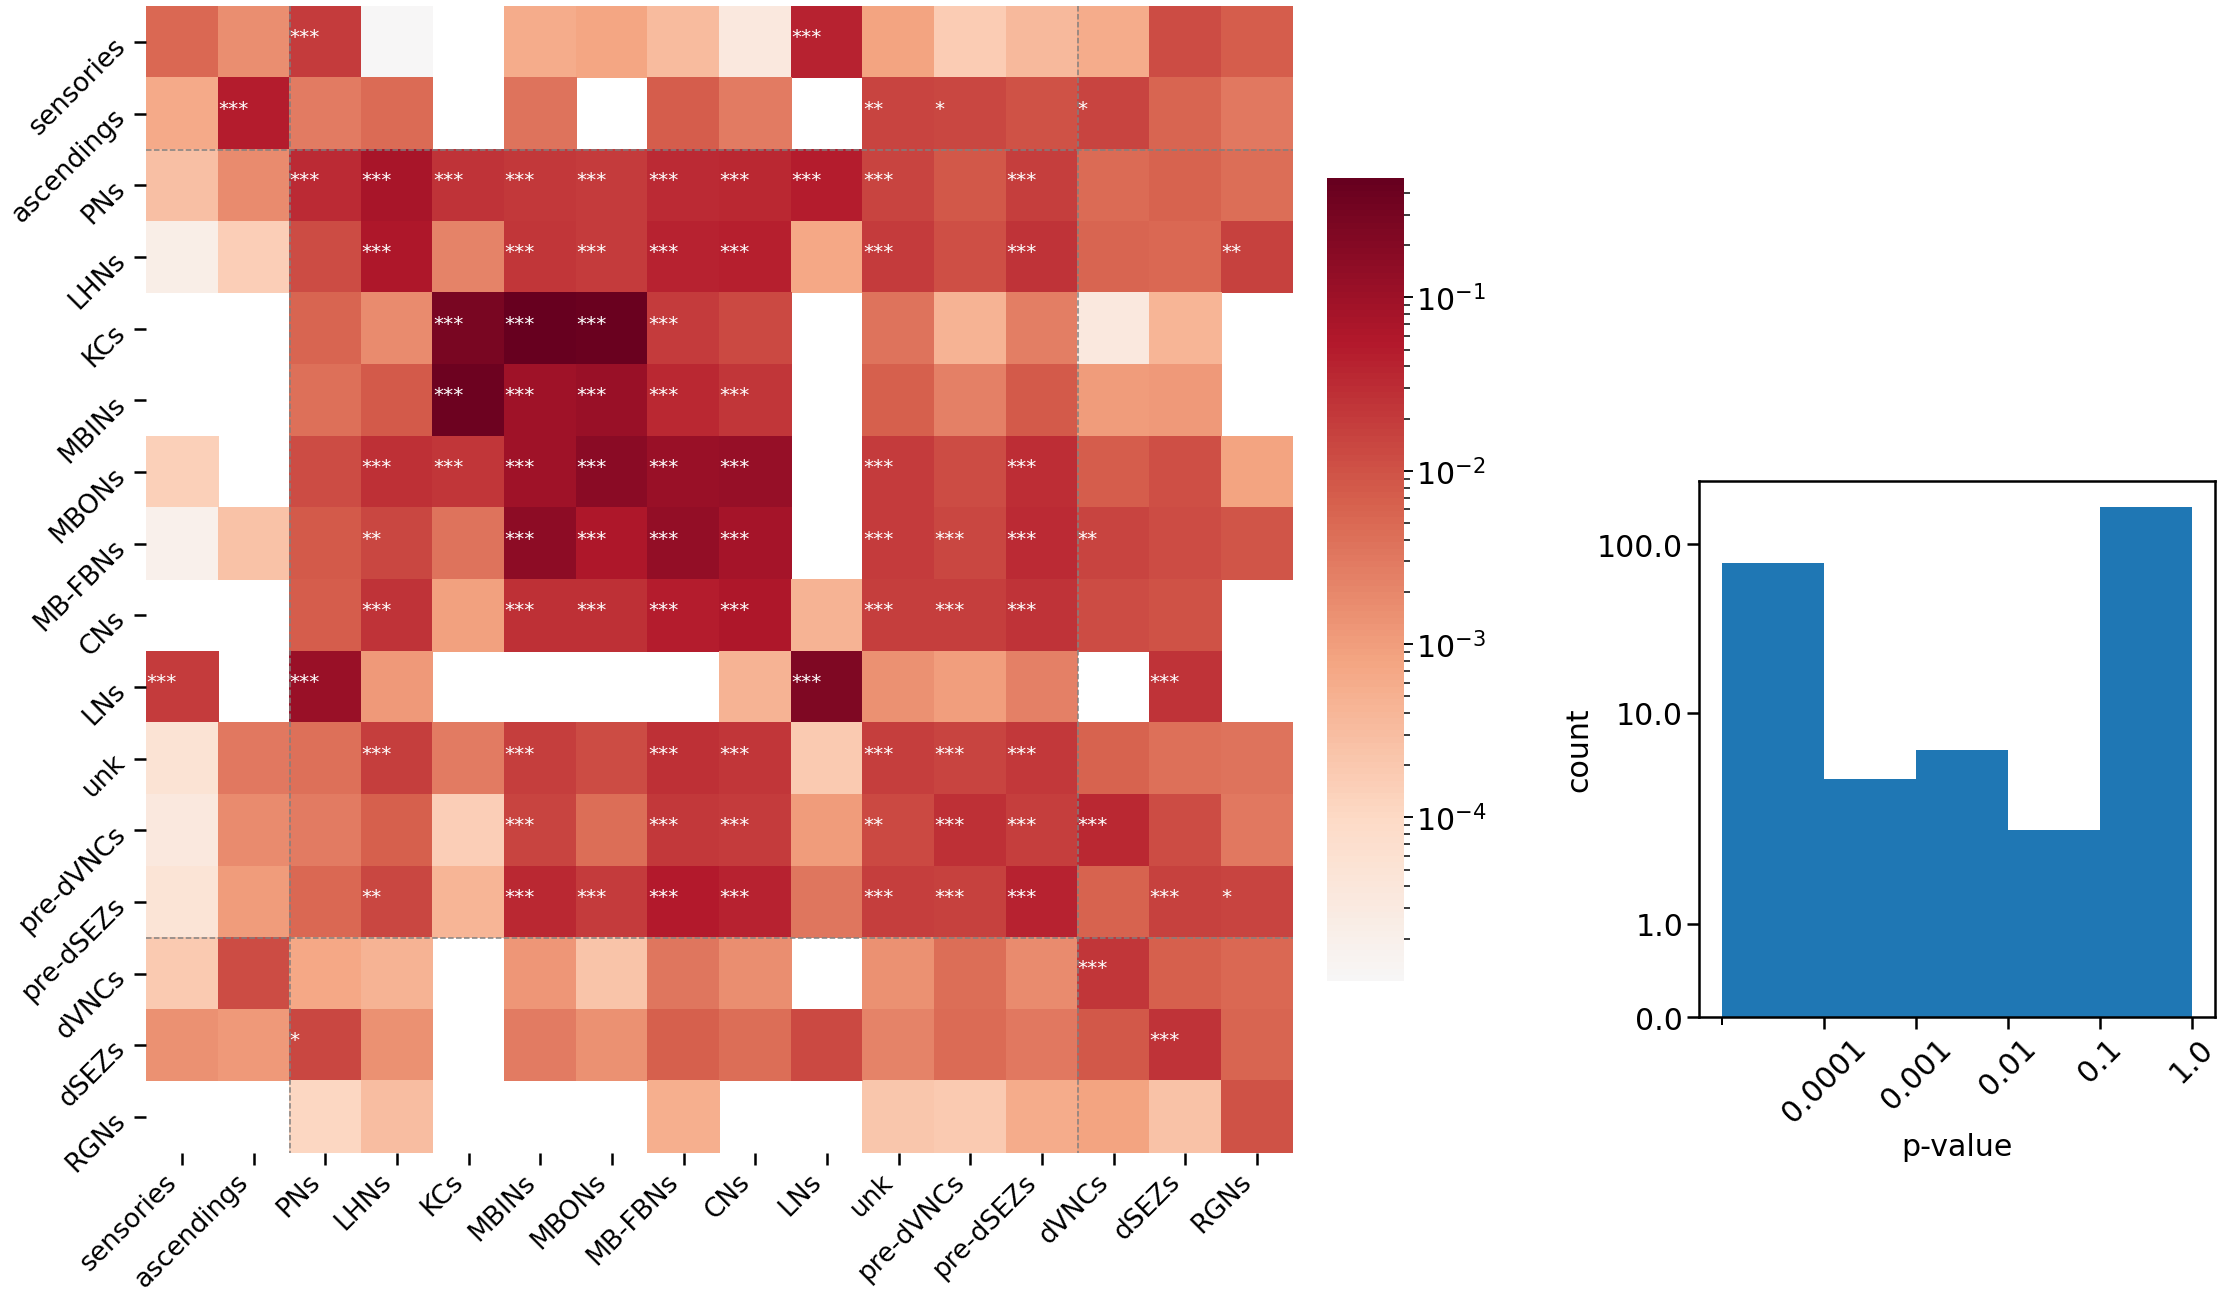

In [15]:
# for 'simple_group'
cls_name = 'simple_group'
idx = [14,9,7,2,1,5,6,4,0,3,15,13,12,11,10,8]  # indices for reordering
labels = list(np.unique(meta[cls_name], return_inverse=True)[0])
new_labels = [labels[i] for i in idx]
sbm_id = all_classes.index(cls_name)
B = sbms[sbm_id].block_p_[np.ix_(idx, idx)].copy()
p_val = np.array(p_val_all[cls_name]).reshape(B.shape)[np.ix_(idx, idx)].ravel()
split = [2, 13]
plot_heatmap(B, new_labels, p_val, block_pairs_all[cls_name])


#%%[markdown]
# #### try to incorporate the edge weights
# in the weighted version, each $B_ij =$ sum of edge weights / no. possible edges
# for significance test, currently using 1 sample z-score -> p-values

In [16]:
block_p, p_mat = weighted_sbm(adj, y=meta['class_4'].values)
p_val, block_pairs = compute_block_sig_wei(block_p, adj, 'class_4', 500)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   18.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:  4.0min finished


/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: The 'linthreshx' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


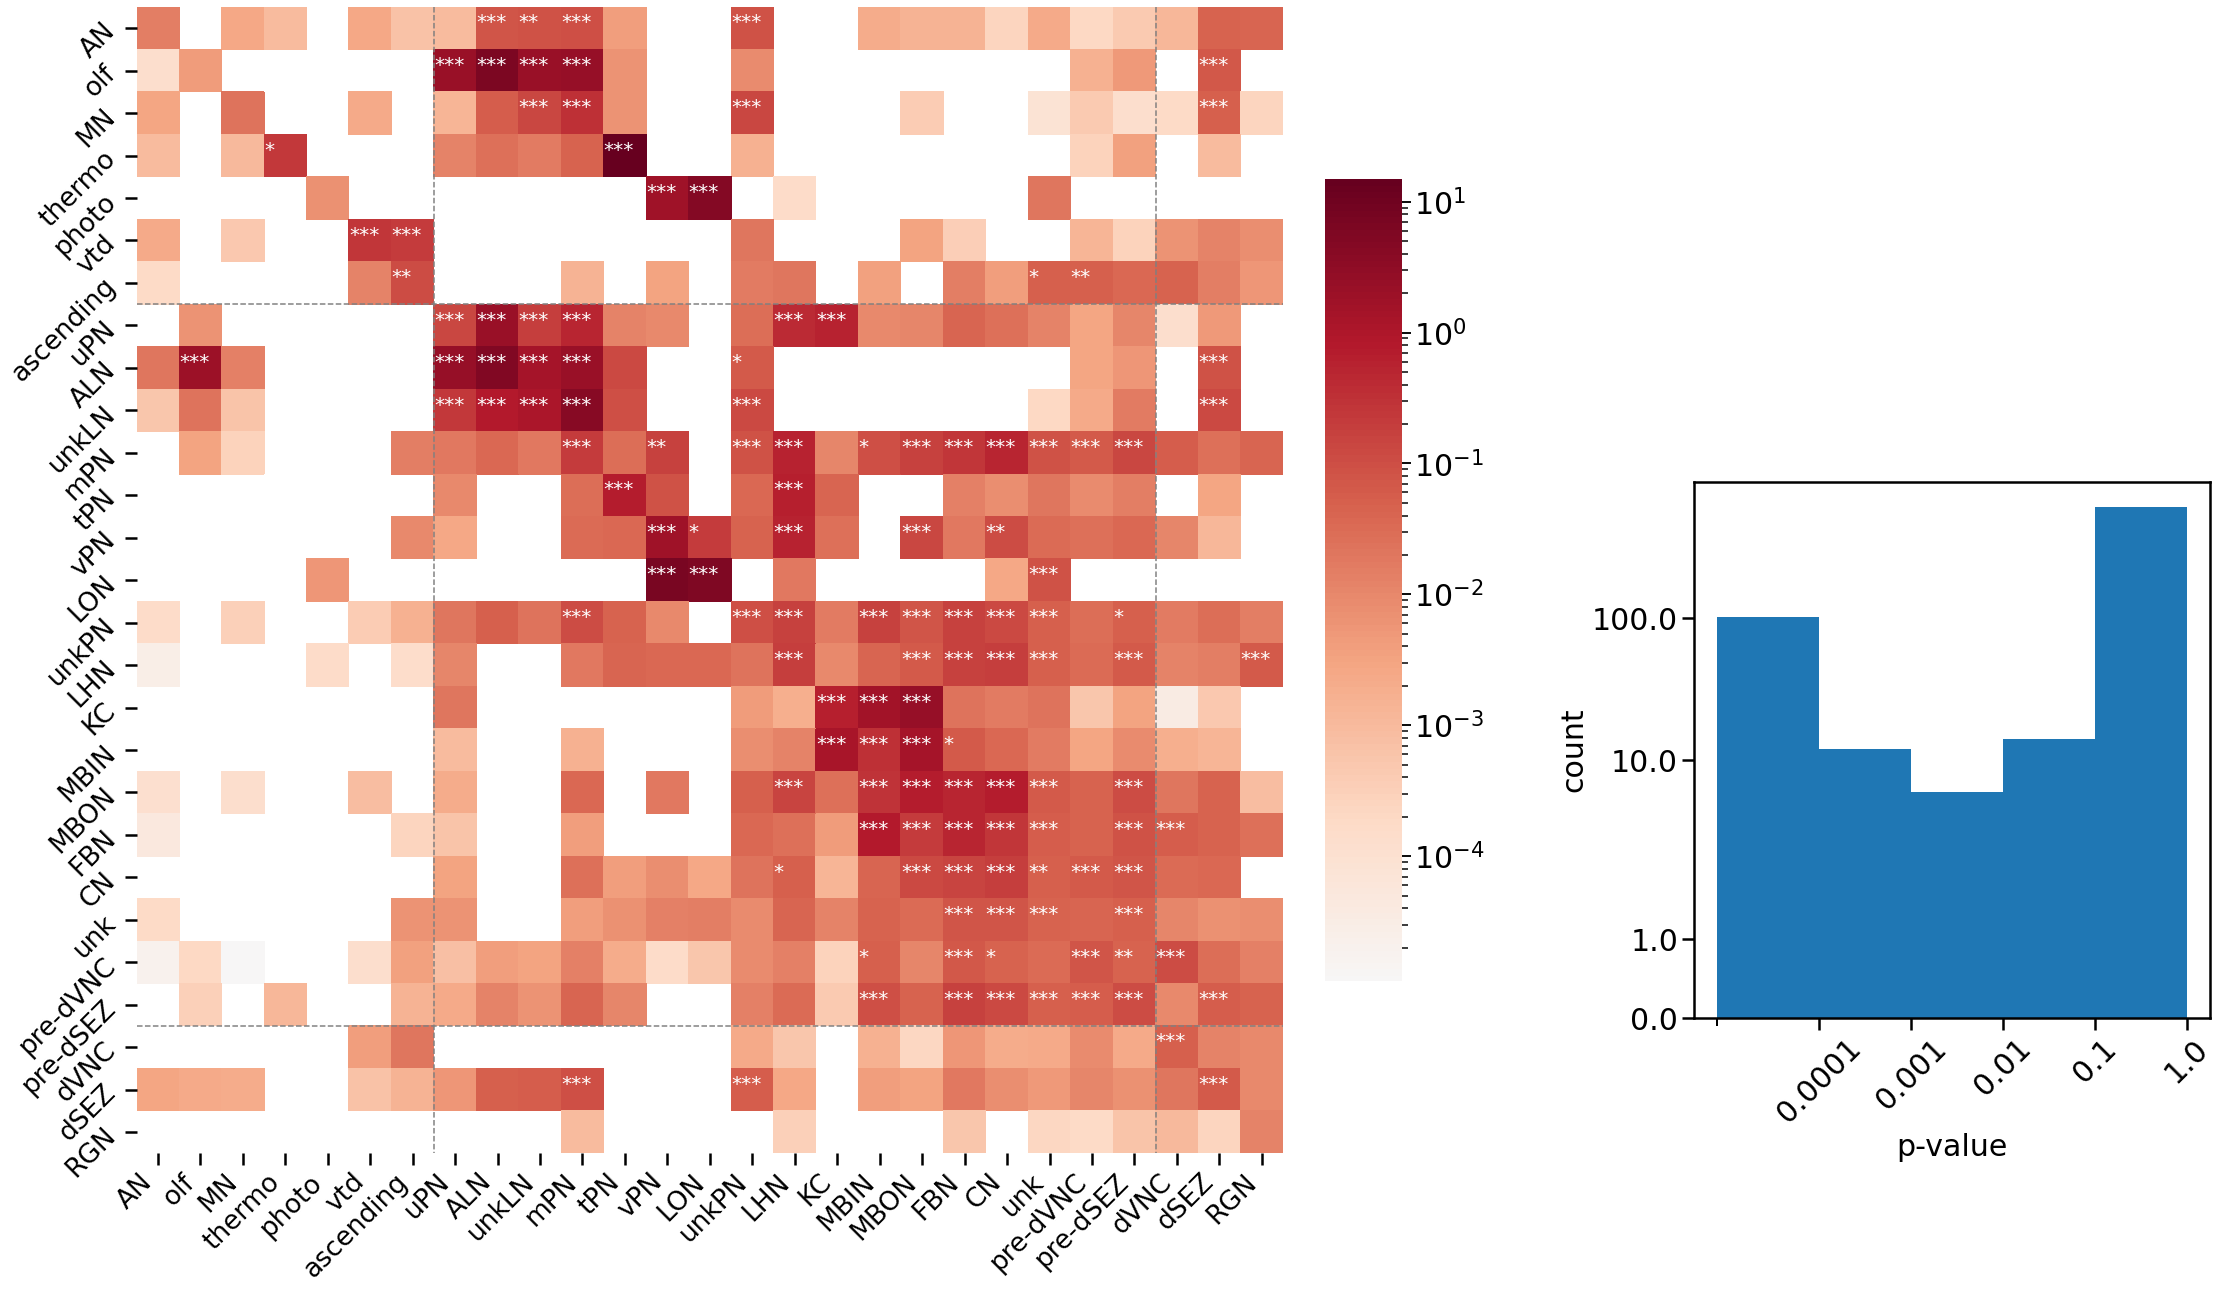

In [17]:
cls = class_4
cls_name = 'class_4'
labels = list(cls.keys())
new_labels = [i.split('_')[-1] for i in labels]
split = [7, 24]
plot_heatmap(block_p, new_labels, p_val, block_pairs)

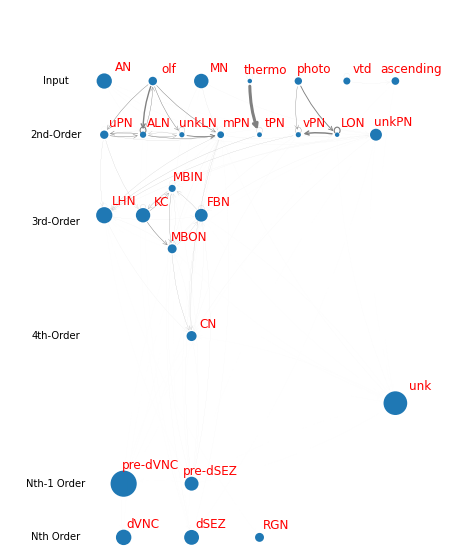

In [18]:
plot_connectivity(cls, block_pairs, block_p, p_val, 3, correc='fdr')

#%%[markdown]
# ### look at the distribution of the edge weights grouped by source & destination

[Text(0.5, 0, 'Edge Weight'), Text(0, 0.5, 'Density')]

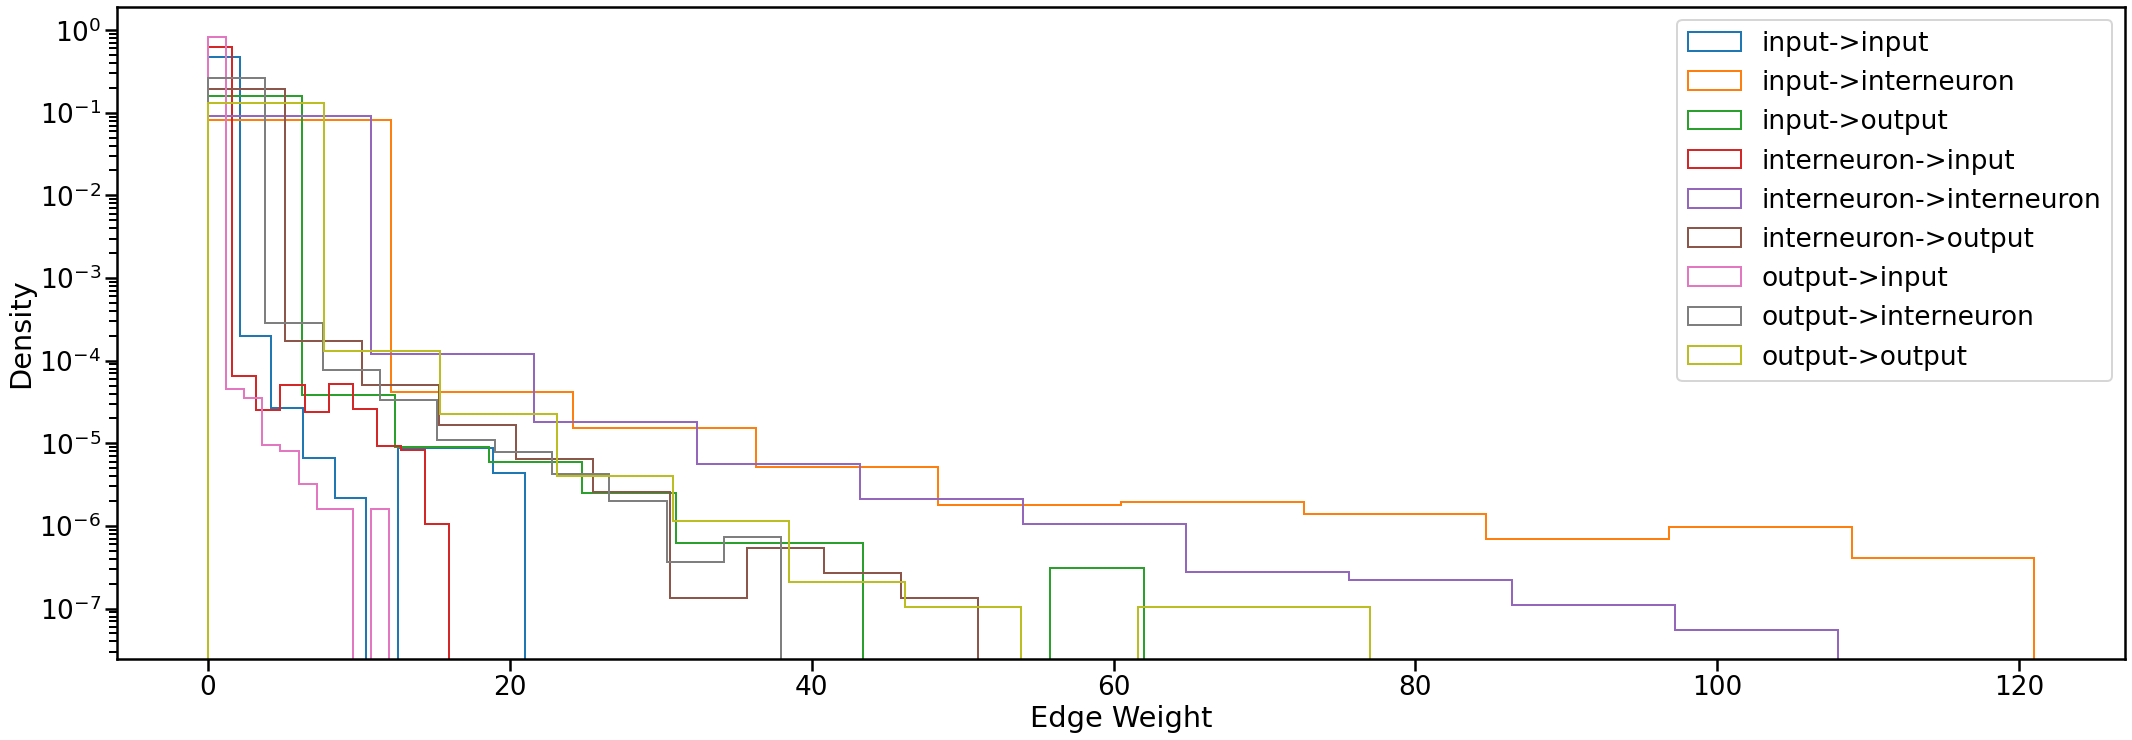

In [19]:
fig,ax = plt.subplots(1,figsize=(36,12))
labels = ['input', 'interneuron', 'output']
for i in range(3):
    for j in range(3):
        idx1 = np.where(meta['class_1'] == i)[0]
        idx2 = np.where(meta['class_1'] == j)[0]
        adj_sub = adj[np.ix_(idx1, idx2)]
        ax.hist(adj_sub.ravel(), log=True, density=True,
        label=labels[i]+"->"+labels[j], histtype=u'step')
ax.legend()
ax.set(xlabel='Edge Weight', ylabel='Density')

In [20]:
# how p-values change from binary to weighted case
# fig,axs = plt.subplots(3,1, figsize=(10,20))
# cuts = [[0,7,7,22],[7,22,7,22],[22,27,22,27]]
# titles = ['input -> interneuron', 'interneuron -> interneuron', 'output -> output']
# for k in range(3):
#     i = np.where(np.logical_and(block_pairs[:,0]>=cuts[k][0],
#         block_pairs[:,0]<cuts[k][1]))[0]
#     j = np.where(np.logical_and(block_pairs[:,1]>=cuts[k][2],
#         block_pairs[:,1]<cuts[k][3]))[0]
#     idx = list(set(i) & set(j))
#     print(len(idx))
#     ax = axs[k]
#     # ax.set_yscale('symlog')
#     # ax.set_xscale('symlog',linthreshx=0.0001)
#     # ax.set_xticks([0.0001, 0.001, 0.01, 0.1, 1])
#     ax.hist(np.array(p_val)[idx], density=True,
#             label='wei', alpha=0.5)
#     ax.hist(np.array(p_val_all['class_4'])[idx], density=True,
#             label='bi', alpha=0.5)
#     ax.set_title(titles[k])
# ax.set_xlabel('p-values')
# plt.legend()

#%%[markdown]
# ### evaluate fitted SBMs

In [21]:
all_cls = ['class_1', 'class_2', 'simple_group', 'class_4']
bic = np.zeros((len(all_cls),2))
lik = np.zeros((len(all_cls),2))
n_params = np.zeros((len(all_cls),2))
estimators = [sbms, sbms_hemi]
for i in range(len(all_cls)):
    labeled = np.where(meta[all_cls[i]].ne(''))[0]
    adj_new = adj[np.ix_(labeled, labeled)]
    for ii,e in enumerate(estimators):
        e[i].n_verts = len(adj_new)
        bic[i,ii] = e[i].bic(binarize(adj_new))
        lik[i,ii] = e[i].score(binarize(adj_new))
        n_params[i,ii] = e[i]._n_parameters()

/Users/TingshanLiu/opt/miniconda3/envs/graspologic2021Jan/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


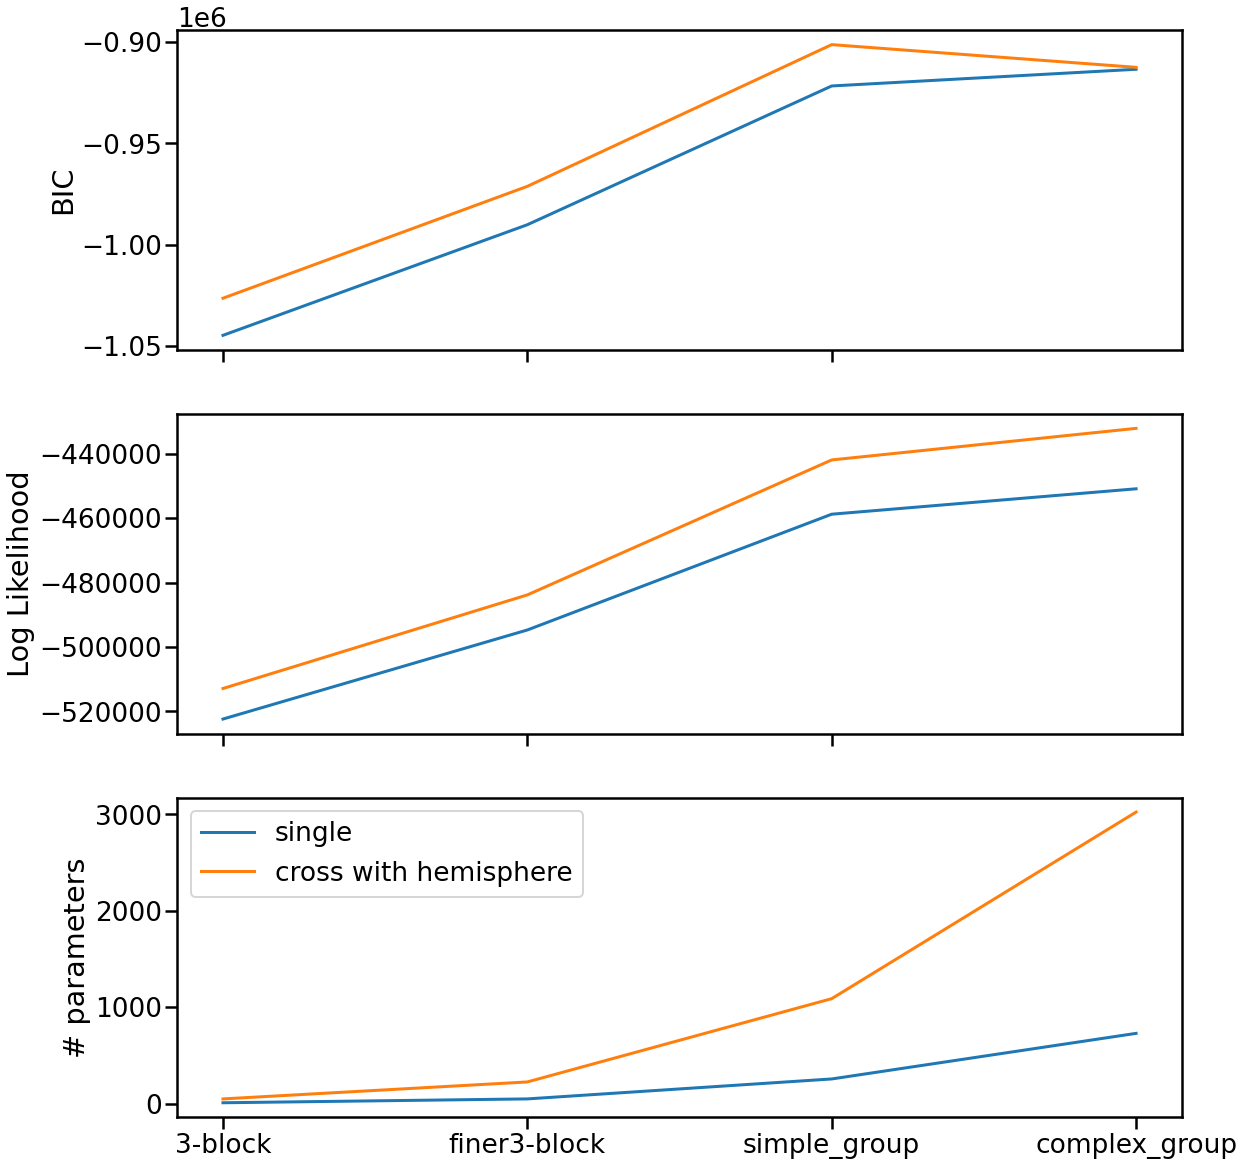

In [22]:
fig,axs = plt.subplots(3,1,figsize=(18,20))
data = [-bic, lik, n_params]
ylabels = ['BIC', 'Log Likelihood', '# parameters']
for i in range(len(data)):
    ax = axs[i]
    ax.plot(data[i][:,0], label='single')
    ax.plot(data[i][:,1], label='cross with hemisphere')
    ax.set_ylabel(ylabels[i])
    if i < 2:
        ax.set(xticklabels='', xticks=range(3))
    else:
        ax.set(xticklabels=['3-block','finer3-block', 'simple_group', 'complex_group'],
        xticks=range(len(all_cls)))
        ax.legend()

[Text(0.5, 0, 'edge weight'), Text(0, 0.5, 'count')]

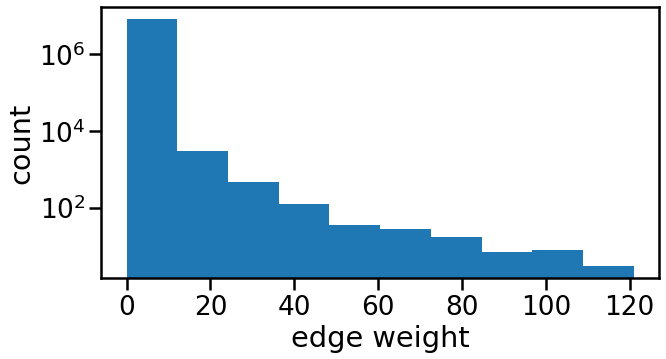

In [23]:
# for the weighted case, assume a zero-inflated Poisson distribution
# parameterized by $\pi$, the proportion of excess zero observations,
# and $\lambda$, the mean of the Poisson distribution
# with pmf: $P(X=0) = \pi + (1-\pi) e^{-\lambda}$
# $P(X=x) = (1-\pi) e^{\lambda} \lambda^x / x! (x>0)$

# ref: https://austinrochford.com/posts/2015-03-03-mle-python-statsmodels.html 
from scipy import stats
def zip_pmf(x, pi, lambda_):
    return (x == 0) * pi + (1 - pi) * stats.poisson.pmf(x, lambda_)

def nloglike(x, pi, lambda_):
    nloglikeobs = -np.log(zip_pmf(x, pi, lambda_))
    return -nloglikeobs.sum(0)

fig,ax = plt.subplots(1, figsize=(10,5))
ax.hist(adj.ravel(), log=True)
ax.set(xlabel='edge weight', ylabel='count')

In [24]:
# # correlation between l-l & r-r/ l-r & r-l blockmodels
# def generate_rand_block_p(adj, y, rep=100, n_jobs=5):
#     def _run():
#         g = er_nm(len(adj), np.count_nonzero(adj), directed=True)
#         sbm_ = model_sbm(g, ['hemisphere', y])
#         return sbm_.block_p_
#     rand_block_p = Parallel(n_jobs=n_jobs, verbose=1)(delayed(_run)()
#         for _ in range(rep))
#     return rand_block_p

In [25]:
# rand_block_p_cls4 = generate_rand_block_p(adj, 'class_4')
# data = rand_block_p_cls4.copy()
# n = int(len(data[0]-1) / 2)  # the 1st block is central so excluded
# def _run(i):
#     B1 = data[i][1:n+1, 1:n+1].ravel()
#     B2 = data[i][n+1:, n+1:].ravel()
#     return Dcorr().test(B1, B2)
# stat = Parallel(n_jobs=5, verbose=1)(delayed(_run)(i)
#     for i in range(len(data)))

In [26]:
stat_ipsi = []
stat_contra = []
for i in range(4):
    idx = i
    n = int(len(sbms_hemi[idx].block_p_-1) / 2)
    # ipsi
    B1 = sbms_hemi[idx].block_p_[1:n+1, 1:n+1].ravel()
    B2 = sbms_hemi[idx].block_p_[n+1:, n+1:].ravel()
    stat_ipsi.append(Dcorr().test(B1, B2))
    # contra
    B1 = sbms_hemi[idx].block_p_[1:n+1, n+1:].ravel()
    B2 = sbms_hemi[idx].block_p_[n+1:, 1:n+1].ravel()
    stat_contra.append(Dcorr().test(B1, B2))
print('Dcorr test results for ipsi:\n', stat_ipsi)
print('Dcorr test results for contra:\n',stat_contra)

Dcorr test results for ipsi:
 [(0.9923568967356298, 0.001), (0.9891956771222783, 2.0136814469783302e-12), (0.9875885214600122, 3.8114458033692815e-57), (0.9670447248537987, 1.5006434951654555e-155)]
Dcorr test results for contra:
 [(0.9981467626086644, 0.001), (0.9856368909282144, 2.2008755865744213e-12), (0.9770493746245356, 1.4765909331884695e-56), (0.9470387335651952, 2.2271668466923655e-152)]


In [27]:
# B1 = sbms_hemi[3].block_p_[1:n+1, 1:n+1].ravel()
# B2 = sbms_hemi[3].block_p_[n+1:, n+1:].ravel()
# stat_cls4 = Dcorr().test(B1, B2)[0]
# stat_cls4_ = [i[0] for i in stat]
# z_score = (stat_cls4 - np.mean(stat_cls4_)) / np.std(stat_cls4_)
# p = 1 - norm.cdf(z_score)
# print(p)
# # compare 2 correlations of independent samples (z-score=1.44, p=0.075 1-tail)

In [28]:
# significance test for the norm diff between ipsi/contra subgraphs

from graspologic.embed import AdjacencySpectralEmbed
from graspologic.utils import symmetrize, multigraph_lcc_intersection
from pkg.utils import get_paired_inds, get_paired_subgraphs
lp_inds, rp_inds = get_paired_inds(meta)
left_meta = meta.iloc[lp_inds]
right_meta = meta.iloc[rp_inds]

ll_adj, rr_adj, lr_adj, rl_adj = get_paired_subgraphs(adj, lp_inds, rp_inds)

# adjs, lcc_inds = multigraph_lcc_intersection([ll_adj, rr_adj], return_inds=True)
# ll_adj = adjs[0]
# rr_adj = adjs[1]
print(f"Norm of left-left adjacency: {np.linalg.norm(binarize(ll_adj))}")
print(f"Norm of right-right adjacency: {np.linalg.norm(binarize(rr_adj))}")
print(f"Norm of left-right adjacency: {np.linalg.norm(binarize(lr_adj))}")
print(f"Norm of right-left adjacency: {np.linalg.norm(binarize(rl_adj))}")

Norm of left-left adjacency: 163.4839441657804
Norm of right-right adjacency: 169.97058569058353
Norm of left-right adjacency: 119.00840306465759
Norm of right-left adjacency: 117.22201158485551


In [29]:
def rand_norm_diff(adj, y, rep=100, n_jobs=5):
    def _run():
        g = er_nm(len(adj), np.count_nonzero(adj), directed=True)
        n = int(len(adj)/2)
        G = [g[:n,:n], g[n:,n:]]
        norm1 = np.linalg.norm(binarize(G[0]))
        norm2 = np.linalg.norm(binarize(G[1]))
        return norm1-norm2
    norm_diff = Parallel(n_jobs=n_jobs, verbose=1)(delayed(_run)()
        for _ in range(rep))
    return norm_diff

adj_paired = np.hstack((np.vstack((ll_adj, lr_adj)), np.vstack((rl_adj, rr_adj))))
n = int(len(ll_adj))
label = np.array([[0]*n,[1]*n]).flatten()
norm_diff = rand_norm_diff(adj_paired, label, 500)
print('99% confidence interval:\n',
    stats.norm.interval(0.99, loc=np.mean(norm_diff), scale=np.std(norm_diff)))

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   19.8s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   45.7s


99% confidence interval:
 (-1.6994324619233117, 1.7833621678712166)


[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:   52.0s finished
